In [1]:
!pip install pytorch-metric-learning
from fastai.vision.all import *

In [2]:
label_func = parent_label
def get_image_files_sample(path):
    files = get_image_files(path)
    label_to_files = defaultdict(list)
    for file in files:
        label = label_func(file)
        label_to_files[label].append(file)
    sampled_files = []
    for files in label_to_files.values():
        sampled_files.extend(random.sample(files, min(50, len(files))))
    return sampled_files

path=untar_data(URLs.CIFAR)
import torchvision.transforms as tt
aug_tfms=tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                           tt.RandomHorizontalFlip()])
class MAIRTransform(DisplayedTransform):
    split_idx,order=0,2
    def encodes(self, img: PILImage):
        return aug_tfms(img)
item_tfms = [MAIRTransform()]
clean_cifar = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                    get_items = get_image_files_sample,
                    splitter  = FuncSplitter(lambda s: Path(s).parent.parent.name == 'test'),                    
                    get_y=label_func,
                    item_tfms=item_tfms,
                    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                    )
loaders = clean_cifar.dataloaders(path, bs=120)

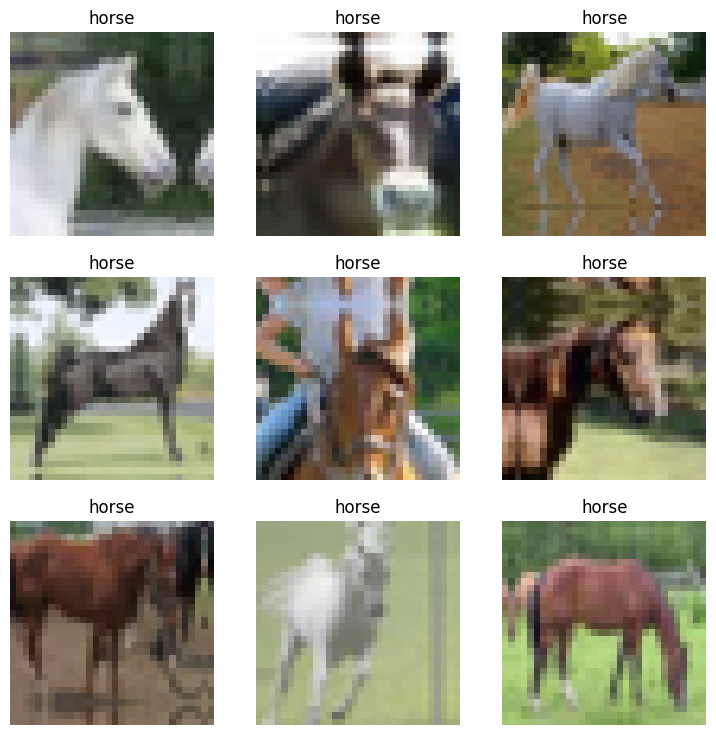

In [3]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers, samplers
sampler = samplers.MPerClassSampler(loaders.vocab, m=12, batch_size=120, length_before_new_iter=loaders.train.n)
#Fastai 会自动创建一个新的数据加载器，该数据加载器使用相同的数据集，但使用您传递的修改后的关键字参数。
loaders.train = loaders.train.new(shuffle=False, sampler=sampler)
loaders.show_batch()

In [4]:
class CustomModel(nn.Module):
    def __init__(self, encoder, head):
        super().__init__()
        self.encoder = encoder
        self.head = head
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))  # Add this line

    def forward(self, x):
        embeddings = self.get_embedding(x)
        classifications = self.head(embeddings)
        return self.avgpool(embeddings).view(embeddings.size(0), -1), classifications

    def get_embedding(self, x):
        x = self.encoder(x)
        return x
    
def siamese_splitter(model):
    return [params(model.module.encoder), params(model.module.head)]    

backbone=resnet18(weights="DEFAULT")
encoder = create_body(backbone)
head = create_head(512, len(loaders.vocab), [1024, 512], 0.5, bn_final=True)
# apply_init(head, nn.init.kaiming_normal_)
model=CustomModel(encoder, head)
model=torch.nn.DataParallel(model)

In [5]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from torchvision import datasets, transforms
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)
def mined_loss(miner, loss_func):
    def loss(embeddings, labels):
      mined = miner(embeddings, labels)
      return loss_func(embeddings, labels, mined)
    return loss
  
similarity_loss = mined_loss(miner = mining_func,
                     loss_func = loss_func)

In [6]:
def pgd(model, data, target, epsilon=0.031, step_size=0.007, num_steps=10,loss_fn="cent",category="Madry",rand_init=True):
    model.eval()
    if category == "trades":
        x_adv = data.detach() + 0.001 * torch.randn(data.shape).cuda().detach() if rand_init else data.detach()
    if category == "Madry":
        x_adv = data.detach() + torch.from_numpy(np.random.uniform(-epsilon, epsilon, data.shape)).float().cuda() if rand_init else data.detach()
        x_adv = torch.clamp(x_adv, 0.0, 1.0)
    for k in range(num_steps):
        x_adv.requires_grad_()
        output = model(x_adv)[-1]
        model.zero_grad()
        with torch.enable_grad():
            if loss_fn == "cent":
                loss_adv = nn.CrossEntropyLoss(reduction="mean")(output, target)
            if loss_fn == "cw":
                loss_adv = cwloss(output,target)
        loss_adv.backward()
        eta = step_size * x_adv.grad.sign()
        x_adv = x_adv.detach() + eta
        x_adv = torch.min(torch.max(x_adv, data - epsilon), data + epsilon)
        x_adv = torch.clamp(x_adv, 0.0, 1.0)
    return x_adv

In [7]:
def early_stop(model, data, target, step_size=0.007, epsilon=0.031, perturb_steps=10,tau=1,randominit_type="uniform_randominit",loss_fn="cent",rand_init=True,omega=0):  
    model.eval()

    K = perturb_steps
    count = 0
    output_target = []
    output_adv = []
    output_natural = []

    control = (torch.ones(len(target)) * tau).cuda()

    # Initialize the adversarial data with random noise
    if rand_init:
        if randominit_type == "normal_distribution_randominit":
            iter_adv = data.detach() + 0.001 * torch.randn(data.shape).cuda().detach()
            iter_adv = torch.clamp(iter_adv, 0.0, 1.0)
        if randominit_type == "uniform_randominit":
            iter_adv = data.detach() + torch.from_numpy(np.random.uniform(-epsilon, epsilon, data.shape)).float().cuda()
            iter_adv = torch.clamp(iter_adv, 0.0, 1.0)
    else:
        iter_adv = data.cuda().detach()

    iter_clean_data = data.cuda().detach()
    iter_target = target.cuda().detach()
    output_iter_clean_data = model(data)[-1]

    while K>0:
        iter_adv.requires_grad_()
        output = model(iter_adv)[-1]
        pred = output.max(1, keepdim=True)[1]
        output_index = []
        iter_index = []

        # Calculate the indexes of adversarial data those still needs to be iterated
        for idx in range(len(pred)):
            if pred[idx] != iter_target[idx]:
                if control[idx] == 0:
                    output_index.append(idx)
                else:
                    control[idx] -= 1
                    iter_index.append(idx)
            else:
                iter_index.append(idx)

        # Add adversarial data those do not need any more iteration into set output_adv
        if len(output_index) != 0:
            if len(output_target) == 0:
                # incorrect adv data should not keep iterated
                output_adv = iter_adv[output_index].reshape((-1,)+data.shape[1:])
                output_natural = iter_clean_data[output_index].reshape((-1,)+data.shape[1:])
                output_target = iter_target[output_index].reshape(-1)
            else:
                # incorrect adv data should not keep iterated
                output_adv = torch.cat((output_adv, iter_adv[output_index].reshape((-1,)+data.shape[1:])), dim=0)
                output_natural = torch.cat((output_natural, iter_clean_data[output_index].reshape((-1,)+data.shape[1:])), dim=0)
                output_target = torch.cat((output_target, iter_target[output_index].reshape(-1)), dim=0)

        # calculate gradient
        model.zero_grad()
        with torch.enable_grad():
            if loss_fn == "cent":
                loss_adv = nn.CrossEntropyLoss(reduction='mean')(output, iter_target)
            if loss_fn == "kl":
                criterion_kl = nn.KLDivLoss(size_average=False).cuda()
                loss_adv = criterion_kl(F.log_softmax(output, dim=1),F.softmax(output_iter_clean_data, dim=1))
        loss_adv.backward(retain_graph=True)
        grad = iter_adv.grad

        # update iter adv
        if len(iter_index) != 0:
            control = control[iter_index]
            iter_adv = iter_adv[iter_index]
            iter_clean_data = iter_clean_data[iter_index]
            iter_target = iter_target[iter_index]
            output_iter_clean_data = output_iter_clean_data[iter_index]
            grad = grad[iter_index]
            eta = step_size * grad.sign().cuda()

            iter_adv = iter_adv.detach() + eta + omega * torch.randn(iter_adv.shape).detach().cuda()
            iter_adv = torch.min(torch.max(iter_adv, iter_clean_data - epsilon), iter_clean_data + epsilon)
            iter_adv = torch.clamp(iter_adv, 0, 1)
            count += len(iter_target)
        else:
            output_adv = output_adv.detach()
            return output_adv, output_target, output_natural, count
        K = K-1

    if len(output_target) == 0:
        output_target = iter_target.reshape(-1).squeeze()
        output_adv = iter_adv.reshape((-1,)+data.shape[1:])
        output_natural = iter_clean_data.reshape((-1,)+data.shape[1:])
    else:
        output_adv = torch.cat((output_adv, iter_adv.reshape((-1,)+data.shape[1:])), dim=0)
        output_target = torch.cat((output_target, iter_target.reshape(-1)), dim=0).squeeze()
        output_natural = torch.cat((output_natural, iter_clean_data.reshape((-1,)+data.shape[1:])),dim=0)
    output_adv = output_adv.detach()
    return output_adv, output_target, output_natural, count

In [8]:
classification_loss = torch.nn.CrossEntropyLoss()
BETA = 100
def att_cb(cb, xb, yb):
    pred = cb.model(*xb)[-1]
    cb.learn.logits_clean=pred
    cb.learn.loss_ce = nn.CrossEntropyLoss(reduction="mean")(TensorBase(pred), TensorBase(yb[0]))
#     with torch.enable_grad():
#         imgs=pgd(model,TensorBase(xb[0]),TensorBase(yb[0]))
#     model.train()
    with torch.enable_grad():
        output_adv, output_target, output_natural, count=early_stop(model,TensorBase(xb[0]),TensorBase(yb[0]))
    model.train()
#     for (x, y) in np.ndindex(imgs.shape[:2]):
#         img=Image.fromarray(img_as_ubyte(imgs[x,y].cpu().numpy()))
#         imgs[x,y]=torch.from_numpy(img_as_float(img.convert("1")))
    return (output_adv,),(output_target,)

loss_metric_names=["simi_loss", "class_loss","loss_kl"] 

class CombinedLoss(nn.Module):  
    def forward(self,preds, target):
        embeddings, classifications = preds
        embed_loss = similarity_loss(embeddings, target)
        class_loss = classification_loss(classifications, target)
        self.simi_loss=embed_loss
        self.class_loss=class_loss
        probs_clean = F.softmax(learn.logits_clean, dim=1)
        log_probs_adv = F.log_softmax(classifications, dim=1)
        self.loss_kl = nn.KLDivLoss(size_average=False)(log_probs_adv, probs_clean)
        return BETA * self.simi_loss +  self.class_loss + self.loss_kl / BETA

def cus_accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[-1].argmax(dim=axis), targ)
    return (pred == targ).float().mean()
loss_func=CombinedLoss()
learn=Learner(loaders, model,loss_func=loss_func, metrics=[cus_accuracy]+LossMetrics(loss_metric_names), splitter=siamese_splitter, cbs=[before_batch_cb(att_cb)])

In [9]:
learn.fine_tune(90,freeze_epochs=10)

epoch,train_loss,valid_loss,cus_accuracy,simi_loss,class_loss,loss_kl,time
0,15.549124,15.353170,0.062500,0.122973,2.794615,26.128742,00:07
1,15.591117,15.282420,0.093750,0.122044,2.793380,28.462059,00:03
2,15.620168,15.411595,0.046875,0.122800,2.819564,31.198372,00:03
3,15.544937,15.280068,0.078125,0.120413,2.783469,45.526573,00:03
4,15.471169,15.307155,0.140625,0.120430,2.732287,53.182381,00:04
5,15.389654,15.619390,0.062500,0.121628,2.742445,71.410126,00:04
6,15.290833,15.353302,0.140625,0.121421,2.512606,69.856102,00:04
7,15.217952,14.823450,0.171875,0.119198,2.303586,60.008480,00:04
8,15.155404,14.903721,0.156250,0.119731,2.351474,57.914322,00:04
9,15.058577,14.716331,0.156250,0.119067,2.321790,48.780018,00:04


/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch,train_loss,valid_loss,cus_accuracy,simi_loss,class_loss,loss_kl,time
0,14.401335,14.998546,0.140625,0.122700,2.329405,39.909252,00:04
1,14.427012,14.768828,0.125000,0.121086,2.302535,35.769604,00:04
2,14.386488,14.788507,0.187500,0.121630,2.289319,33.622528,00:04
3,14.316761,14.831839,0.140625,0.122262,2.308418,29.719534,00:04
4,14.299903,14.578796,0.171875,0.120241,2.263513,29.123238,00:04
5,14.264336,14.498235,0.125000,0.119602,2.254501,28.348785,00:04
6,14.268626,14.679111,0.140625,0.121529,2.260185,26.607380,00:04
7,14.254641,14.597596,0.171875,0.120725,2.269607,25.550858,00:04
8,14.234492,14.673609,0.171875,0.121755,2.251807,24.627613,00:04
9,14.220263,14.380692,0.171875,0.118939,2.255363,23.144196,00:04
